In [1]:
import numpy as np
import scanpy as sc

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

%matplotlib inline

/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and preprocess data

In [2]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

100%|██████████| 972M/972M [00:49<00:00, 20.5MB/s]  


In [3]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


In [5]:
adata = adata[:, adata.var.highly_variable].copy()

In [6]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [ ]:
# save the adata object
adata.write_h5ad('../data/scib_metrics_reproduce/lung_atlas_preprocessed.h5ad')

# Run methods

In [8]:
adata = sc.read_h5ad('../data/scib_metrics_reproduce/lung_atlas_preprocessed.h5ad')

## Scanorama

In [9]:
import scanorama

# List of adata per batch
batch_cats = adata.obs.batch.cat.categories
adata_list = [adata[adata.obs.batch == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["Scanorama"][adata.obs.batch == b] = adata_list[i].obsm["X_scanorama"]

Found 2000 genes among all datasets
[[0.00000000e+00 5.35398230e-01 2.57743363e-01 1.58185841e-01
  4.93362832e-01 1.81415929e-01 1.88053097e-02 7.63274336e-02
  6.63716814e-03 3.31858407e-03 7.74336283e-03 1.10619469e-02
  1.10619469e-03 9.95575221e-03 1.10619469e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.66666667e-01 2.64587525e-01
  3.27464789e-01 4.08953722e-01 3.47082495e-02 3.11871227e-02
  3.26264274e-03 2.36418511e-02 1.57938487e-02 1.00603622e-02
  1.35814889e-02 1.45875252e-02 9.94243851e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.48484848e-01
  7.90043290e-01 5.95238095e-01 1.89701897e-02 1.08225108e-02
  1.73160173e-02 1.29870130e-02 4.32900433e-02 2.16450216e-03
  8.65800866e-03 8.65800866e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.65657839e-01 2.74515015e-01 2.11382114e-02 1.03163686e-02
  2.44698206e-03 1.13475177e-02 3.36658354e-02 8.71369295e-03
  2.33644860e-03 0.00000000e+00

## Liger

In [5]:
import pyliger

bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib

## Harmony

In [6]:
from harmony import harmonize

adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="batch")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


## scVI

In [7]:
import scvi

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()

/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performan

Epoch 246/246: 100%|██████████| 246/246 [09:58<00:00,  2.42s/it, v_num=1, train_loss_step=521, train_loss_epoch=518]

`Trainer.fit` stopped: `max_epochs=246` reached.


Epoch 246/246: 100%|██████████| 246/246 [09:58<00:00,  2.43s/it, v_num=1, train_loss_step=521, train_loss_epoch=518]


In [14]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
adata.obsm["scANVI"] = lvae.get_latent_representation()

INFO     Training for 20 epochs.                                                                                   


/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performan

Epoch 20/20: 100%|██████████| 20/20 [02:08<00:00,  6.84s/it, v_num=1, train_loss_step=538, train_loss_epoch=501]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:08<00:00,  6.44s/it, v_num=1, train_loss_step=538, train_loss_epoch=501]


In [15]:
# save the adata object
adata.write_h5ad('../data/scib_metrics_reproduce/lung_atlas_integrated.h5ad')

# Perform the benchmark

In [2]:
# load the adata object
adata = sc.read_h5ad('../data/scib_metrics_reproduce/lung_atlas_integrated.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'pca'
    obsm: 'Harmony', 'LIGER', 'Scanorama', 'Unintegrated', 'X_pca', 'scANVI', 'scVI'
    varm: 'PCs'
    layers: 'counts'

In [4]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    embedding_obsm_keys=["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", "scANVI"],
    n_jobs=6,
)
bm.benchmark()

/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
Embeddings:   0%|          | 0/6 [00:00<?, ?it/s]/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/scib_metrics/metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setti

## Visualize the results

/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/scib_metrics/benchmark/_core.py:295: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/scib_metrics/benchmark/_core.py:295: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/wynton/group/gartner/zuzhi/.conda/envs/scenv/lib/python3.13/site-packages/scib_metrics/benchmark/_core.py:295: FutureWarning: Setting an item of incompatible dtype is depr

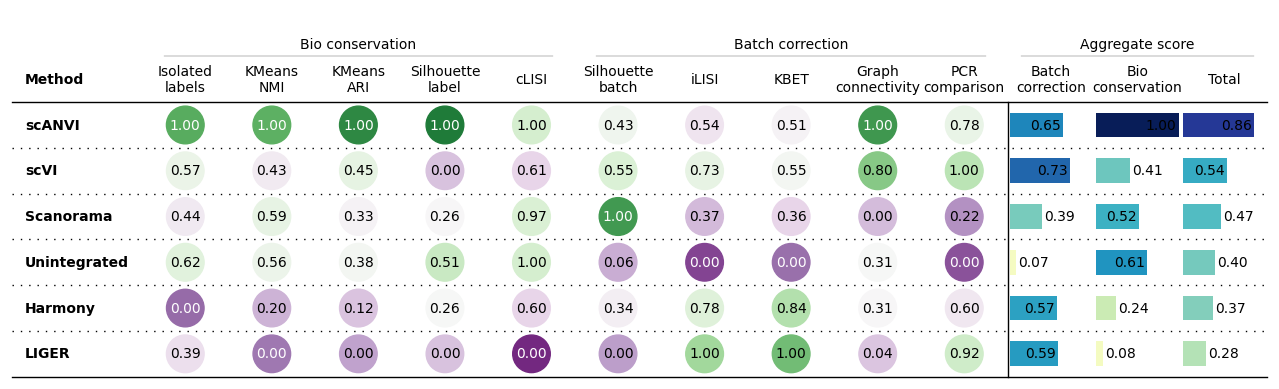

In [5]:
bm.plot_results_table()

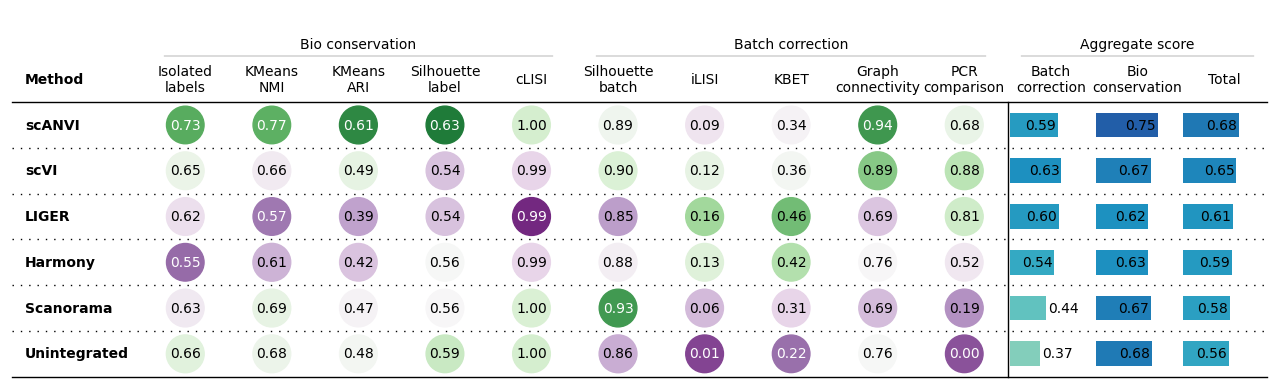

In [6]:
bm.plot_results_table(min_max_scale=False)

In [22]:
from rich import print

df = bm.get_results(min_max_scale=False)
print(df)

Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                            
Unintegrated          0.661278          0.682006          0.476682   
Scanorama             0.629303          0.687599          0.465441   
LIGER                 0.621488          0.573194          0.393748   
Harmony               0.553521          0.612256          0.419719   
scVI                  0.652657          0.656413          0.492364   
scANVI                0.727732          0.768365           0.61133   
Metric Type   Bio conservation  Bio conservation  Bio conservation   

              Silhouette label             cLISI  Silhouette batch  \
Embedding                                                            
Unintegrated          0.585415               1.0          0.855258   
Scanorama             0.564254          0.999608          0.932356   
LIGER                 0.542106           0.98501          0.850703   
Harmony               0.564291          0.994061          0.878215   
scVI                  0.542329          0.994097          0.895679   
scANVI                0.626858               1.0          0.886082   
Metric Type   Bio conservation  Bio conservation  Batch correction   

                         iLISI              KBET Graph connectivity  \
Embedding                                                             
Unintegrated          0.008071               NaN           0.764946   
Scanorama             0.064781               NaN           0.685215   
LIGER                  0.16332               NaN           0.694717   
Harmony               0.129168               NaN           0.764602   
scVI                  0.121944               NaN           0.892532   
scANVI                0.092016               NaN            0.94473   
Metric Type   Batch correction  Batch correction   Batch correction   

                PCR comparison Batch correction Bio conservation  \
Embedding                                                          
Unintegrated                 0         0.407069         0.681076   
Scanorama             0.191227         0.468395         0.669241   
LIGER                 0.810099          0.62971         0.623109   
Harmony               0.523149         0.573784         0.628769   
scVI                  0.878009         0.697041         0.667572   
scANVI                0.683244         0.651518         0.746857   
Metric Type   Batch correction  Aggregate score  Aggregate score   

                        Total  
Embedding                      
Unintegrated         0.571473  
Scanorama            0.588902  
LIGER                0.625749  
Harmony              0.606775  
scVI                  0.67936  
scANVI               0.708721  
Metric Type   Aggregate score

# Debug KBET score

In [2]:
adata = sc.read_h5ad('../data/scib_metrics_reproduce/lung_atlas_integrated.h5ad')
adata

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'pca'
    obsm: 'Harmony', 'LIGER', 'Scanorama', 'Unintegrated', 'X_pca', 'scANVI', 'scVI'
    varm: 'PCs'
    layers: 'counts'

In [6]:
bm = Benchmarker(
    adata=adata,
    batch_key="batch",
    label_key="cell_type",  # optional for KBET, still required by Benchmarker
    embedding_obsm_keys=["Harmony","LIGER"],  # or your set
    pre_integrated_embedding_obsm_key="X_pca",
    bio_conservation_metrics=BioConservation(
        nmi_ari_cluster_labels_kmeans=False,
        silhouette_label=True,
        clisi_knn=False,
        isolated_labels=False,
    ),
    batch_correction_metrics=BatchCorrection(
        silhouette_batch=True,
        ilisi_knn=False,
        kbet_per_label=True,  # ✅ this enables KBET
        graph_connectivity=False,
        pcr_comparison=False,
    ),
    n_jobs=2,
)

bm.benchmark()

Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

INFO     17 clusters consist of a single batch or are too small. Skip.                                             


/wynton/group/gartner/zuzhi/.conda/envs/scenv_v2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])
Embeddings:  50%|█████     | 1/2 [00:03<00:03,  3.63s/it]

INFO     17 clusters consist of a single batch or are too small. Skip.                                             


/wynton/group/gartner/zuzhi/.conda/envs/scenv_v2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])
Embeddings: 100%|██████████| 2/2 [00:07<00:00,  3.67s/it]


In [7]:
bm.benchmark()

/wynton/group/gartner/zuzhi/.conda/envs/scenv_v2/lib/python3.13/site-packages/scib_metrics/benchmark/_core.py:213: UserWarning: The benchmark has already been run. Running it again will overwrite the previous results.
  warnings.warn(
Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

INFO     17 clusters consist of a single batch or are too small. Skip.                                             


/wynton/group/gartner/zuzhi/.conda/envs/scenv_v2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])
Embeddings:  50%|█████     | 1/2 [00:03<00:03,  3.01s/it]

INFO     17 clusters consist of a single batch or are too small. Skip.                                             


/wynton/group/gartner/zuzhi/.conda/envs/scenv_v2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])
Embeddings: 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]


In [8]:
import pandas as pd
pd.crosstab(adata.obs["cell_type"], adata.obs["batch"])


batch,1,2,3,4,5,6,A1,A2,A3,A4,A5,A6,B1,B2,B3,B4
cell_type,,,,,,,,,,,,,,,,
B cell,9,11,3,4,23,2,5,3,1,1,26,15,6,16,17,1211
Basal 1,0,0,0,0,2,0,530,485,260,218,13,464,0,0,0,0
Basal 2,0,4,0,2,1,0,355,353,200,157,1465,535,0,0,0,0
Ciliated,0,65,12,8,57,0,488,346,487,195,442,622,81,211,136,5
Dendritic cell,17,230,98,150,182,495,32,29,5,20,95,14,0,0,0,0
Endothelium,157,0,0,48,101,12,36,8,26,9,108,123,40,76,162,82
Fibroblast,5,46,25,212,139,51,5,7,3,5,20,11,25,32,124,23
Ionocytes,0,0,0,0,0,0,3,21,9,10,2,1,0,0,0,0
Lymphatic,0,0,0,76,68,0,0,0,1,0,1,0,44,126,22,3


/wynton/group/gartner/zuzhi/.conda/envs/scenv_v2/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


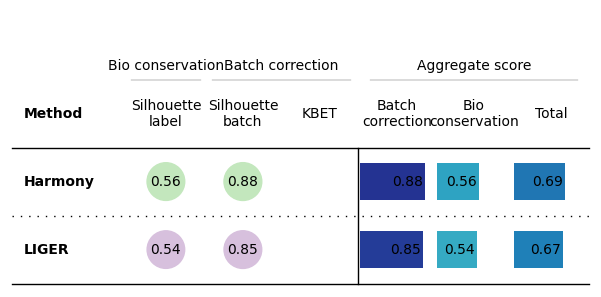

In [6]:
bm.plot_results_table(min_max_scale=False)

In [15]:
bm.get_results()

/wynton/group/gartner/zuzhi/.conda/envs/scenv_v2/lib/python3.13/site-packages/sklearn/utils/_array_api.py:686: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/wynton/group/gartner/zuzhi/.conda/envs/scenv_v2/lib/python3.13/site-packages/sklearn/utils/_array_api.py:706: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/wynton/group/gartner/zuzhi/.conda/envs/scenv_v2/lib/python3.13/site-packages/scib_metrics/benchmark/_core.py:291: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/wynton/group/gartner/zuzhi/.conda/envs/scenv_v2/lib/python3.13/site-packages/scib_metrics/benchmark/_core.py:291: FutureWarning: Setting an item of incompatible dtype is deprecated

,Silhouette label,Silhouette batch,KBET,Batch correction,Bio conservation,Total
Embedding,,,,,,
Harmony,1.0,1.0,NaN,1.0,1.0,1.0
LIGER,0.0,0.0,NaN,0.0,0.0,0.0
Metric Type,Bio conservation,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score
